In this repository we look through how we can implement Recurrent Neural Network using Tensorflow . we are going to plot a simple sine wave say sin(x)

In [1]:
# imports

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size,1) 
        
        # Convert to be on time series
        ts_start = rand_start * (self.xmax- self.xmin - (steps*self.resolution) )
        
        # Create batch Time Series on t axis
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        # Create Y data for time series in the batches
        y_batch = np.sin(batch_ts)
        
        # Format for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) ,batch_ts
        
        else:
            
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 
        

In [3]:
# passing values

ts_data = TimeSeriesData(250,0,10)     # we need 250 values between 0 and 10

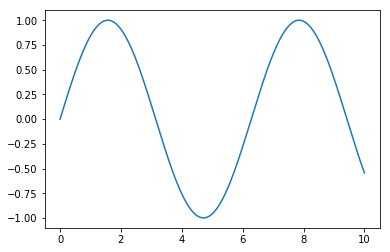

In [4]:
plt.plot(ts_data.x_data,ts_data.y_true)


In [5]:
# Lets say we want each random batches to have 30 steps in it

num_time_steps = 30


In [6]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

In [7]:
ts.flatten()

array([4.33668965, 4.37668965, 4.41668965, 4.45668965, 4.49668965,
       4.53668965, 4.57668965, 4.61668965, 4.65668965, 4.69668965,
       4.73668965, 4.77668965, 4.81668965, 4.85668965, 4.89668965,
       4.93668965, 4.97668965, 5.01668965, 5.05668965, 5.09668965,
       5.13668965, 5.17668965, 5.21668965, 5.25668965, 5.29668965,
       5.33668965, 5.37668965, 5.41668965, 5.45668965, 5.49668965,
       5.53668965])

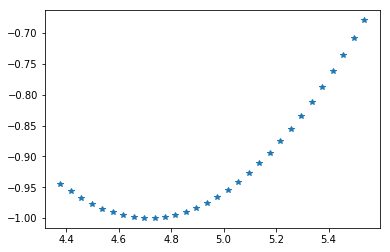

In [8]:
# re running above statement and this one provides differnt batch from sine wave each time

plt.plot(ts.flatten()[1:],y2.flatten(),'*')

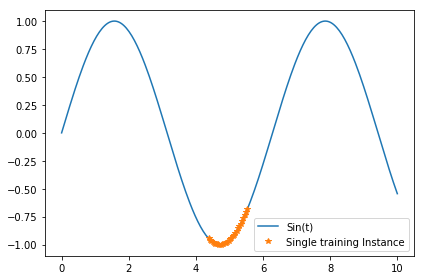

In [9]:
plt.plot(ts_data.x_data,ts_data.y_true,label = 'Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label ='Single training Instance')

plt.legend()
plt.tight_layout()    # spaces the legend properly

In [10]:
# TRAINING DATA

In [11]:
train_inst = np.linspace(5,5 + ts_data.resolution *(num_time_steps+1),num_time_steps+1)

In [12]:
train_inst

array([5.        , 5.04133333, 5.08266667, 5.124     , 5.16533333,
       5.20666667, 5.248     , 5.28933333, 5.33066667, 5.372     ,
       5.41333333, 5.45466667, 5.496     , 5.53733333, 5.57866667,
       5.62      , 5.66133333, 5.70266667, 5.744     , 5.78533333,
       5.82666667, 5.868     , 5.90933333, 5.95066667, 5.992     ,
       6.03333333, 6.07466667, 6.116     , 6.15733333, 6.19866667,
       6.24      ])

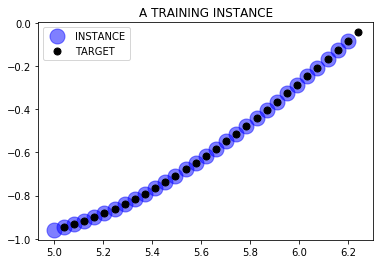

In [13]:
plt.title('A TRAINING INSTANCE')

plt.plot(train_inst[:-1],ts_data.ret_true(train_inst[:-1]),'bo',markersize = 15,alpha =0.5,label ='INSTANCE')

plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]),'ko',markersize = 7,label ='TARGET')

plt.legend()

In [14]:
# given these blue points as series can you generate a series of black points i.e series shifted over one time step ??

In [15]:
# CREATING THE MODEL

In [16]:
tf.reset_default_graph()

In [17]:
num_inputs = 1

In [18]:
num_neurons = 100     # 100 neurons in one layer

In [19]:
num_outputs = 1

In [20]:
learning_rate = 0.0001

In [21]:
num_train_iterations = 2000

In [22]:
batch_size = 1

In [23]:
# PLACEHOLDERS

In [24]:
X =tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])

In [25]:
y = tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

In [26]:
# create neural network cell layer

# cell = tf.contrib.rnn.BasicRNNCell(num_units = num_neurons ,activation = tf.nn.relu)

cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(num_units = num_neurons ,activation = tf.nn.relu),output_size=num_outputs)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [30]:
outputs,states =  tf.nn.dynamic_rnn(cell,X,dtype = tf.float32)

In [31]:
# loss function mean squared error
loss = tf.reduce_mean(tf.square(outputs - y)) 

In [32]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [33]:
train = optimizer.minimize(loss)

In [34]:
init = tf.global_variables_initializer()

In [37]:
#SESSION
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)

In [38]:
saver = tf.train.Saver()

In [41]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./rnn_time_series_model")

0 	MSE: 0.51403415
100 	MSE: 0.03511689
200 	MSE: 0.010562296
300 	MSE: 0.07704874
400 	MSE: 0.013442976
500 	MSE: 0.0006501492
600 	MSE: 0.007635109
700 	MSE: 0.014318021
800 	MSE: 0.011490967
900 	MSE: 0.0020919756
1000 	MSE: 0.0016085722
1100 	MSE: 0.0049087624
1200 	MSE: 0.008678238
1300 	MSE: 0.00023164244
1400 	MSE: 0.0005922419
1500 	MSE: 0.0018264696
1600 	MSE: 0.00079999457
1700 	MSE: 0.0031657396
1800 	MSE: 0.0010620846
1900 	MSE: 0.003594793


In [42]:
# predicting a time series t+1

In [43]:
with tf.Session() as sess:                          
    saver.restore(sess, "./rnn_time_series_model")   

    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


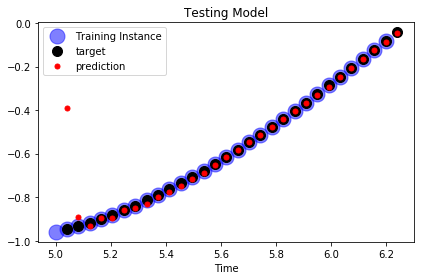

In [44]:
plt.title("Testing Model")

# Training Instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15,alpha=0.5, label="Training Instance")

# Target to Predict
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="target")

# Models Prediction
plt.plot(train_inst[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()